z 스코어로 이상치유무 판단



단순선형회귀
계쑤 1차원 리스트 ,그 외는 그냥텍스트


다중선형회귀
리턴될 떄 계수 2차원
절편 1차원 리스트
>> 그래서 결과값 접근할 때 코드 달라짐

높이 두껩 ㅕㄴ화가 없을 떄 길이가 1 지나면 



스케일링...

estimator.fit() --> 데이터 적합 (학습 규칙 파악,)

estimator.transform() (그 규칙 기반 하에 학습)
estimator.fit_transform (두 개 합친거 규칙도 만들고 학습도 같이 끝내) >> 스케일링



fit transform 이 아니고 transform 만 써야하는 상황 구분 필요






# [LAB 06] 지도학습 > 예측 > 선형 > 02- 다중 선형 회귀

## 농어의 무게 예측 모형
- 다중선형회귀 : 독립변수가 2개 이상 존재
- 다항선형회귀 : 2차항 이상의 독립변수가 존재하는 회귀 모형

분석 정확도를 높이기 위해 적절하지 않은 변수를 추려내는 과정을 반복적으로 수행하여 최적의 독립변수 그룹을 찾아내는 것을 목표로



주요 포인트
- 통제 변수 : 계수 해석 시 '다른 변수들을 고정한다' 의미 내포
- 변수 수 증가의 효과

## #01. 준비 작업
### [1] 패키지 참조

In [67]:
from hossam import *
from pandas import DataFrame, read_excel
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import statsmodels as sm

from itertools import combinations

#데이터 표준화 모듈
from sklearn.preprocessing import StandardScaler

#선형 회귀 분석 모듈
from sklearn.linear_model import LinearRegression

#훈련/검증 데이터 분리 모듈
from sklearn.model_selection import train_test_split


from scipy.stats import pearsonr,spearmanr

### [2] 데이터 가져오기

In [68]:
origin = load_data('fish')
origin.head()

농어의 길이,높이,두께,무게를 조사한 데이터 셋


,길이,높이,두께,무게
0,8.4,2.11,1.41,5.9
1,13.7,3.53,2.00,32.0
2,15.0,3.82,2.43,40.0
3,16.2,4.59,2.63,51.5
4,17.4,4.59,2.94,70.0


## #02. 데이터 확인 및 전처리
### [1] 데이터 품질 검사

In [69]:
# 원본 데이터 프레임 참조 (복사 아님)
# -> 이후 로그 변환용으로 사용하기 위해 이름을 따로 분리하는 용도
df = origin

# 기본 통계량
desc = df.describe().T

# 결측치 확인
desc["missing"] = df.isnull().sum()

# IQR, 이상치 경계, 이상치 수, 이상치 비율
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_count = ((df < lower_bound) | (df > upper_bound)).sum()
outlier_ratio = outlier_count / len(df) * 100

desc["outlier_count"] = outlier_count
desc["outlier_ratio(%)"] = outlier_ratio

# 수치형 컬럼 자동 추출
num_cols = df.select_dtypes(include=np.number).columns

# 왜도 기반 로그 변환 필요성 판단
for column in num_cols:
    skewness = df[column].skew()

    if abs(skewness) < 0.5:
        strength = "weak"
        log_transform = "not needed"
    elif abs(skewness) < 1:
        strength = "normal"
        log_transform = "recommended"
    else:
        strength = "strong"
        log_transform = "needed"

    desc.loc[column, "skewness"] = skewness
    desc.loc[column, "skewness_strength"] = strength
    desc.loc[column, "log_transform"] = log_transform

desc


,count,mean,std,min,25%,50%,75%,max,missing,outlier_count,outlier_ratio(%),skewness,skewness_strength,log_transform
길이,56.0,27.892857,9.021668,8.40,21.825,25.300,36.625,44.00,0,0,0.0,0.270547,weak,not needed
높이,56.0,7.862143,2.878343,2.11,5.690,6.920,10.850,12.80,0,0,0.0,0.361355,weak,not needed
두께,56.0,4.745536,1.775006,1.41,3.520,4.155,6.450,8.14,0,0,0.0,0.424951,weak,not needed
무게,56.0,382.239286,347.617717,5.90,120.000,207.500,692.500,1100.00,0,0,0.0,0.844368,normal,recommended


#### 인사이트

- 결측치 없음
  - 모든 변수에서 missing 값이 0으로, 결측치 처리가 필요하지 않음.

- 이상치 없음
  - outlier_count와 outlier_ratio(%)가 모두 0으로, IQR 기준 이상치가 존재하지 않음.

- 왜도(분포 비대칭성) 약함~보통
  - 길이, 높이, 두께: skewness가 0.5 미만(weak)으로 로그 변환 필요 없음.
  - 무게: skewness가 0.84(normal)로 로그 변환 권장(recommended).

- 변수별 분포 특성
  - 길이, 높이, 두께: 평균과 중앙값(50%)이 유사해 분포가 대체로 대칭적임.
  - 무게: 평균(38.2)과 중앙값(20.75)의 차이가 커서 오른쪽으로 긴 꼬리(positive skew) 분포이며, 로그 변환 시 예측 성능 개선 가능성 있음.

- 전처리 계획
  - 결측치 및 이상치 처리는 불필요.
  - 무게 변수에 한해 로그 변환 적용을 고려(모델 성능 및 분포 정규화 목적).
  - 나머지 변수는 추가 변환 없이 사용 가능.

### [2] 로그 변환

In [70]:
#무게 컬럼에 대해서만 처리
df1 = origin.copy()
df1['무게'] = np.log1p(df1['무게'])
df1.head()

,길이,높이,두께,무게
0,8.4,2.11,1.41,1.931521
1,13.7,3.53,2.00,3.496508
2,15.0,3.82,2.43,3.713572
3,16.2,4.59,2.63,3.960813
4,17.4,4.59,2.94,4.262680


### [3] 상자그림 확인
- 데이터 스케일링 필요 여부를 위해 확인하는 것이므로 종속변수는 제외하고 진행

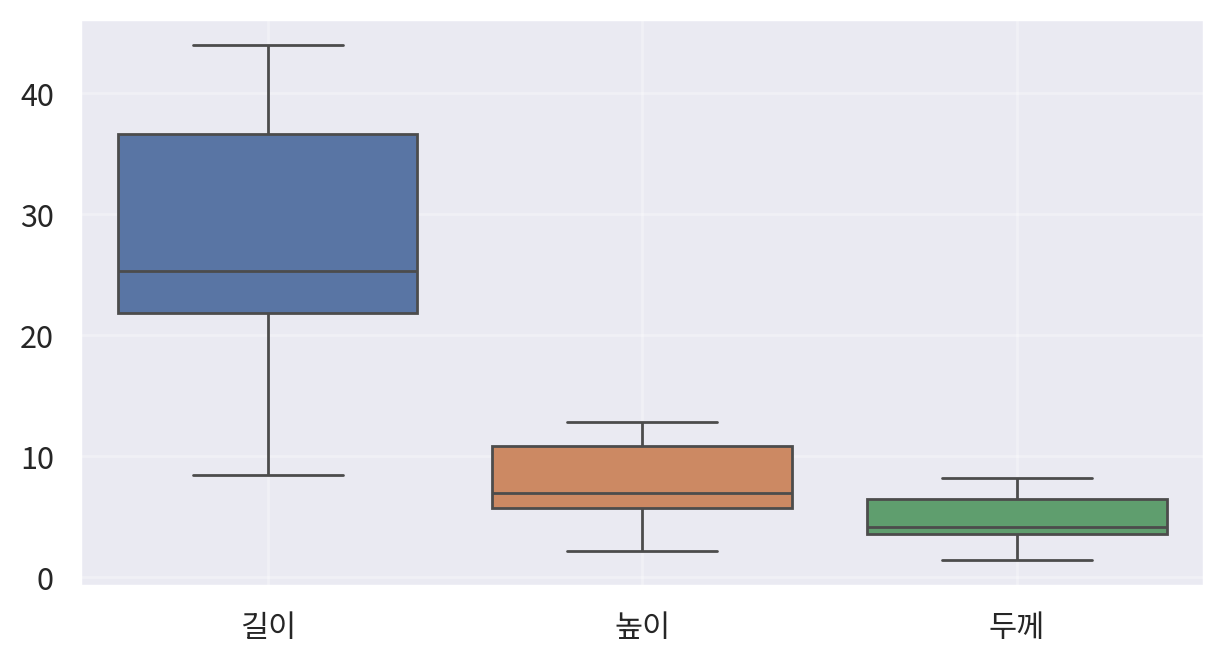

In [71]:
figsize = (1280/my_dpi , 720/my_dpi)
fig,ax = plt.subplots(1,1,figsize=figsize , dpi =my_dpi)


sb.boxplot(data=df1[['길이','높이','두께']])
ax.grid(True,alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

### 인사이트
- 데이터간의 단위 차이가 크므로 스케일링이 권장된다

### [4] 데이터 스케일링
- 스케일링은 독립변수에 대해서만 진행해야 한다

In [72]:
df = df1[['길이','높이','두께']]

scaler = StandardScaler()
df2=DataFrame(scaler.fit_transform(df),columns=df.columns)
df2['무게']=df1['무게']
df2.head()

,길이,높이,두께,무게
0,-2.180225,-2.016507,-1.896175,1.931521
1,-1.587434,-1.518703,-1.560774,3.496508
2,-1.442032,-1.417039,-1.316328,3.713572
3,-1.307815,-1.147103,-1.202633,3.960813
4,-1.173599,-1.147103,-1.026405,4.262680


### [5] 데이터 분포 확인


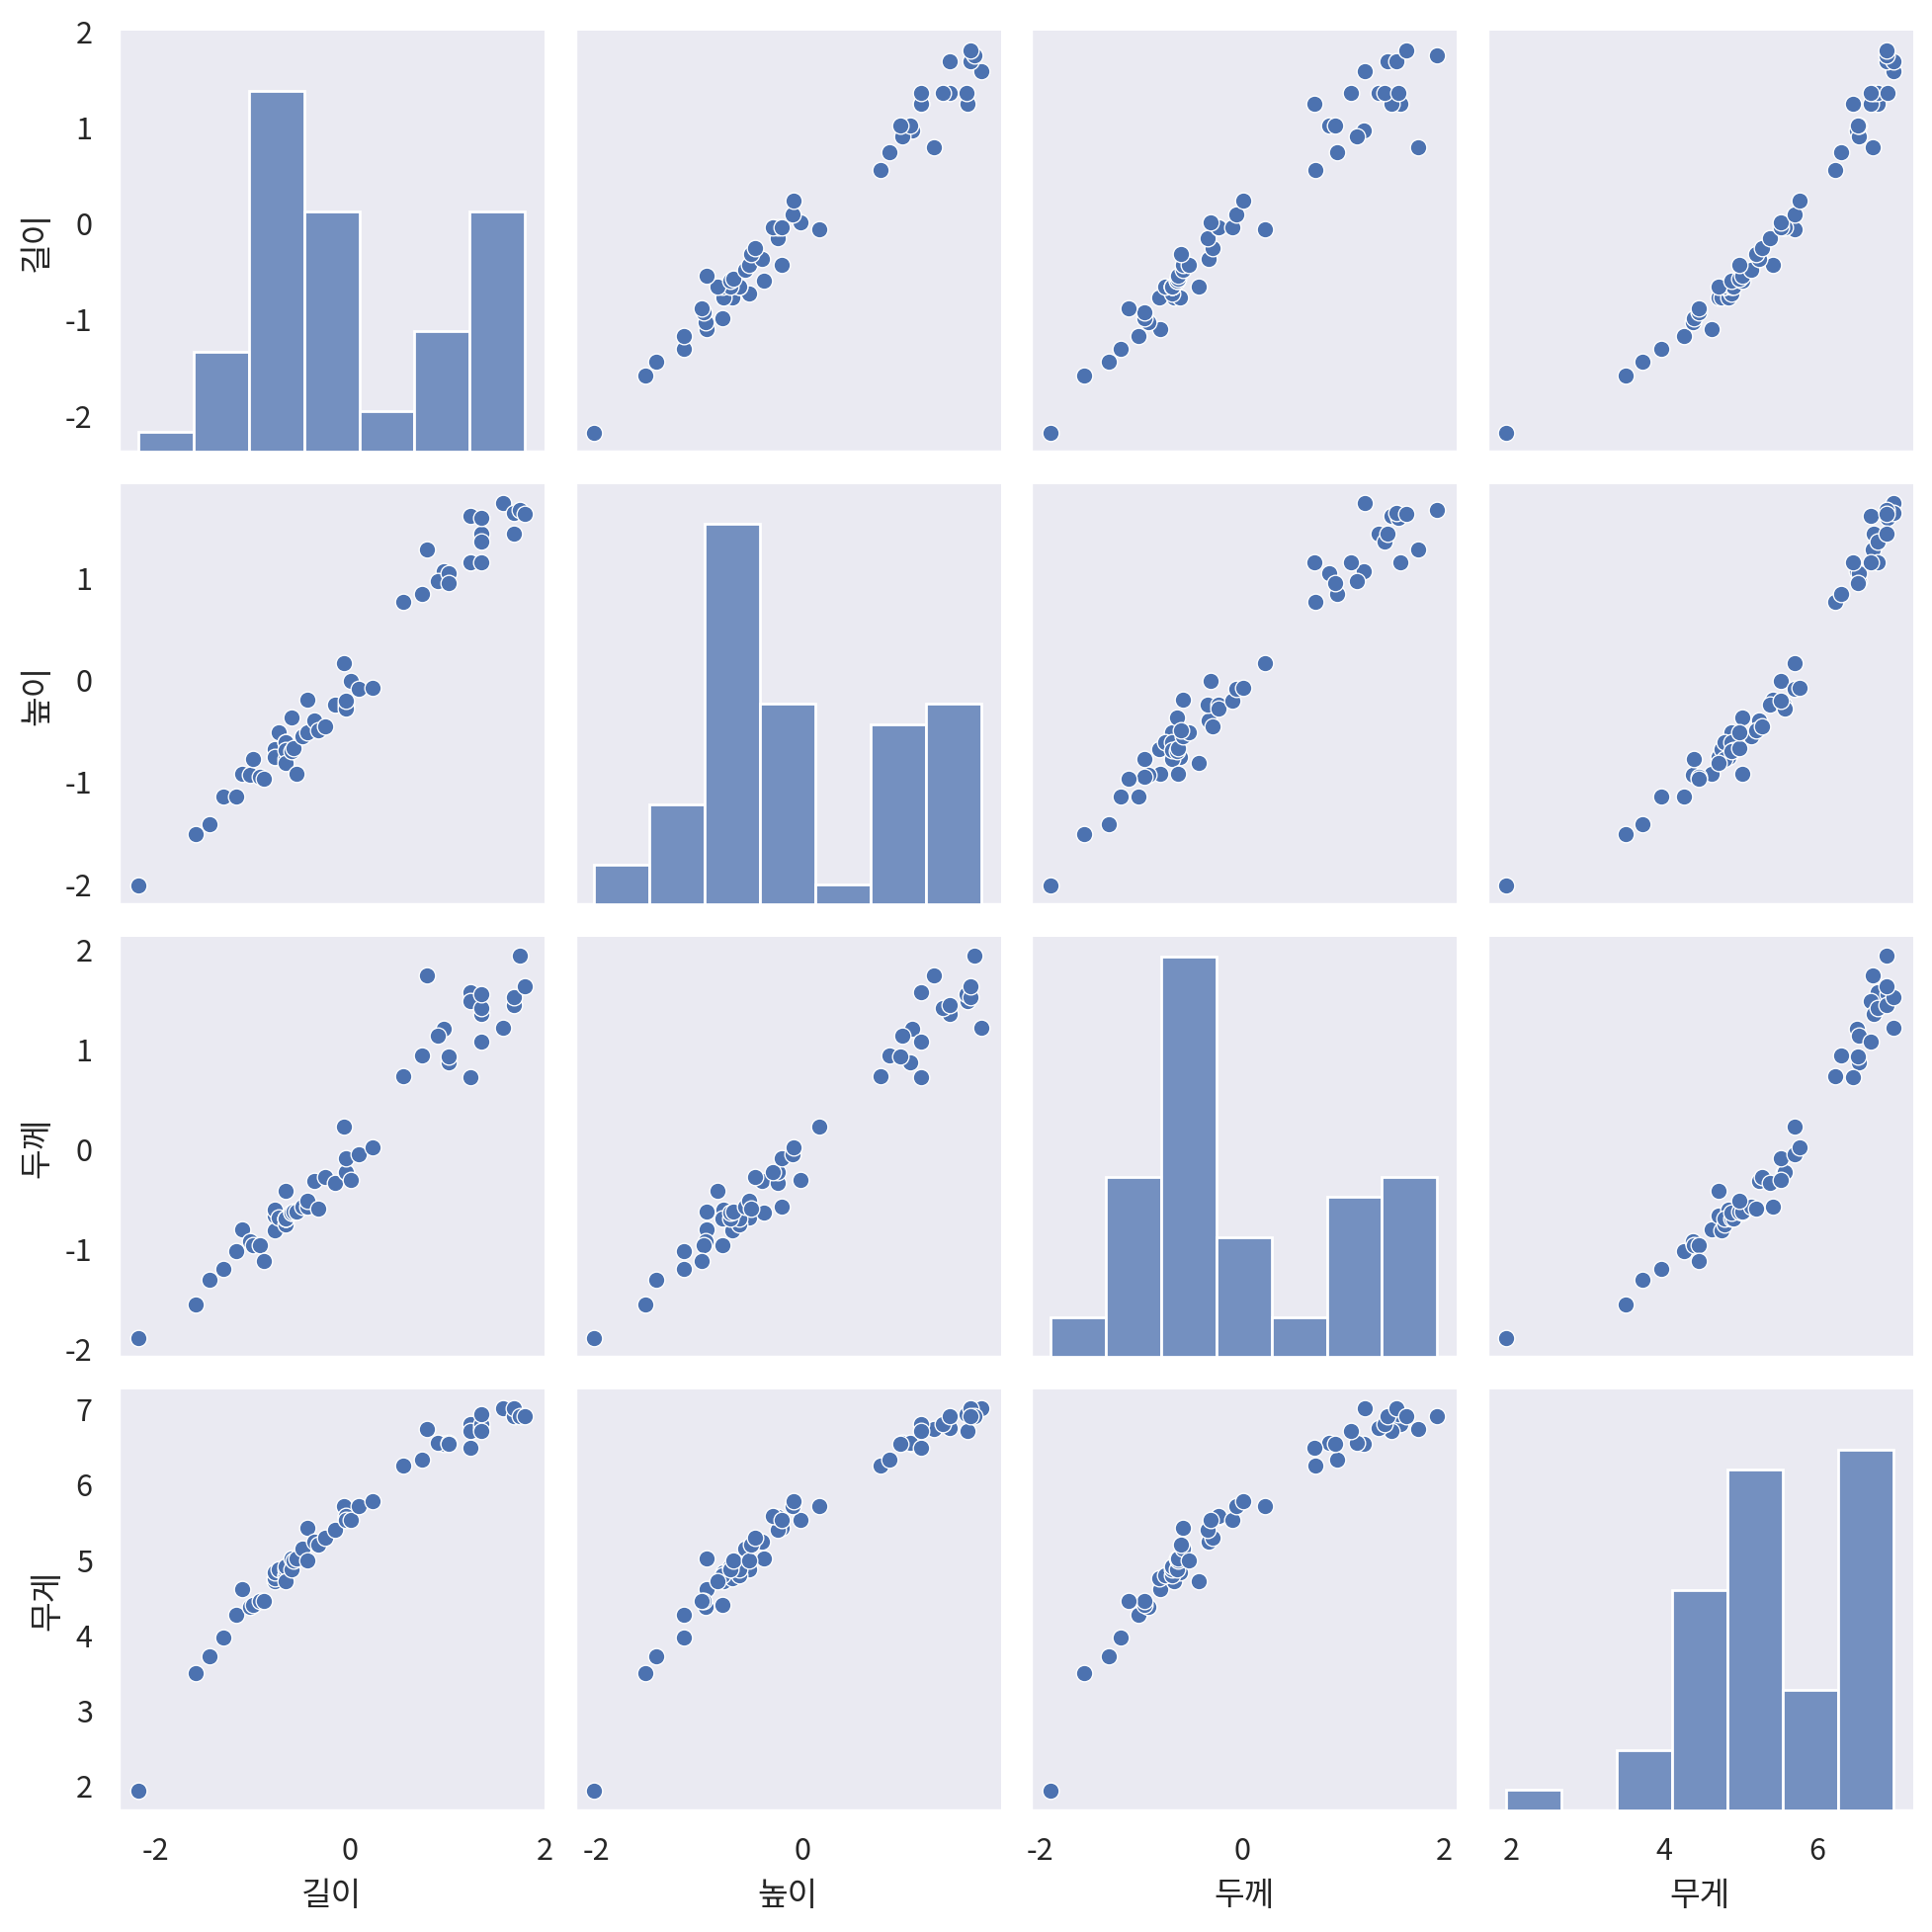

In [73]:
sb.pairplot(df2)
plt.show()
plt.close()

### 인사이트
- 모든 변수가 종속변수인 두꼐에 상관관계가 있는 것으로 보인다
- 무게의 경우, 선형성 가정을 충족하지 않는 것 같지만 ( 비선형), 예제 데이터이므로 선형성 가정을 충족한다고 가정하고 진행한다

## #03. 추론 통계
### [1] 상관 분석
- 변수쌍마다 상관분석을 돌리고, 데이터 상태 (선형성,이상치) 따라 Pearson vs Spearman 을 조건부로 선택해서 결과표를 만드는 코드
- 결과적으로 result_df 테이블을 통해 총 표본소,선형성 통과 여부, 이상치 플래그, 상관계수, pval, 유의여부, 강도 등급 확인 가능

In [74]:
# 원본 데이터 프레임 참조 (복사 아님)
# -> 이후 코드 고정으로 사용하기 위해 객체 이름을 df로 통일하는 용도
data = df2

# 이상치 판단 기준 절대값
z_thresh = 3.0

# 상관분석을 위한 최소 표본 수
min_n = 8

# 유의수준 판단 기준값
alpha = 0.05

# 수치형 컬럼 자동 추출
cols = data.select_dtypes(include=np.number).columns.tolist()

# z-score 기반 이상치 유무 계산
# 결측 제거 후 표준편차가 0이면, 이상치 판단 불가, z-score 계산해서 |z|>3 이 하나라도 있으면 True
z_outlier_flags = {}

for c in cols:
    col = data[c].dropna()
    if col.std(ddof=1) == 0:
        z_outlier_flags[c] = False
        continue

    z = (col - col.mean()) / col.std(ddof=1)
    z_outlier_flags[c] = (z.abs() > z_thresh).any()

rows = []


#변수쌍 2개 반복 블록
#가능한 모든 숫자형 컬럼 조합을 만든다

for a, b in combinations(cols, 2):
    # 공통 관측치 사용
    pair_df = data[[a, b]].dropna()

    if len(pair_df) < max(3, min_n):
        # 표본이 너무 적으면 계산하지 않음
        rows.append(
            {
                "var_a": a,
                "var_b": b,
                "n": len(pair_df),
                "linearity": False,
                "outlier_flag": True,
                "chosen": None,
                "corr": np.nan,
                "pval": np.nan,
                "significant": False,
                "strength": "no correlation",
            }
        )
        continue

    x = pair_df[a]
    y = pair_df[b]

    # 상수열/분산 0 체크 → 상관계수 계산 불가
    if x.nunique(dropna=True) <= 1 or y.nunique(dropna=True) <= 1:
        rows.append(
            {
                "var_a": a,
                "var_b": b,
                "n": len(pair_df),
                "linearity": False,
                "outlier_flag": True,
                "chosen": None,
                "corr": np.nan,
                "pval": np.nan,
                "significant": False,
                "strength": "no correlation",
            }
        )
        continue

    # 1) 선형성: Ramsey RESET (지정 차수 전부 p > alpha 여야 통과)
    linearity_ok = False
    try:
        X_const = sm.add_constant(x)
        model = sm.OLS(y, X_const).fit()
        pvals = []
        for pwr in linearity_power:
            reset = linear_reset(model, power=pwr, use_f=True)
            pvals.append(reset.pvalue)

        if len(pvals) > 0:
            linearity_ok = all(pv > alpha for pv in pvals)
    except Exception:
        linearity_ok = False

    # 2) 이상치 플래그 (두 변수 중 하나라도 z-outlier 있으면 True)
    outlier_flag = bool(z_outlier_flags.get(a, False) or z_outlier_flags.get(b, False))

    # 3) 상관 계산: 선형·무이상치면 Pearson, 아니면 Spearman
    try:
        if linearity_ok and not outlier_flag:
            chosen = "pearson"
            corr_val, pval = pearsonr(x, y)
        else:
            chosen = "spearman"
            corr_val, pval = spearmanr(x, y)
    except Exception:
        chosen = None
        corr_val, pval = np.nan, np.nan

    # 4) 유의성, 강도
    significant = False if np.isnan(pval) else pval <= alpha
    abs_r = 0 if np.isnan(corr_val) else abs(corr_val)

    if abs_r >= 0.7:
        strength = "strong"
    elif abs_r >= 0.3:
        strength = "medium"
    elif abs_r > 0:
        strength = "weak"
    else:
        strength = "no correlation"

    rows.append(
        {
            "var_a": a,
            "var_b": b,
            "n": len(pair_df),
            "linearity": linearity_ok,
            "outlier_flag": outlier_flag,
            "chosen": chosen,
            "corr": corr_val,
            "pval": pval,
            "significant": significant,
            "strength": strength,
        }
    )

result_df = DataFrame(rows)
result_df


,var_a,var_b,n,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,길이,높이,56,False,False,spearman,0.970562,4.577162e-35,True,strong
1,길이,두께,56,False,False,spearman,0.966186,1.826845e-33,True,strong
2,길이,무게,56,False,True,spearman,0.986639,3.061102e-44,True,strong
3,높이,두께,56,False,False,spearman,0.954701,4.233630e-30,True,strong
4,높이,무게,56,False,True,spearman,0.978868,6.598050e-39,True,strong
5,두께,무게,56,False,True,spearman,0.971928,1.291124e-35,True,strong


#### 인사이트
종속변수인 무게는 길이, 높이, 두께와 모두 높은 상관성을 갖는 것으로 보인다.

하지만 독립변수들(길이-높이, 높이-두께, 두께-길이) 사이에도 상관성이 있는 것으로 확인된다. 이러한 경우를 자기상관(다중공선성) 문제가 있다고 하며, 이 상태에서 회귀분석을 수행하면 모델의 신뢰성이 떨어질 수 있다.

정확한 분석을 위해서는 독립변수들의 VIF(Variance Inflation Factor) 를 확인해 다중공선성 문제를 해결해야 한다.
다만, 본 예제 데이터에서는 학습 목적상 다중공선성 문제를 별도로 처리하지 않고 분석을 진행하도록 한다.

### [2] 머신러닝 수행 전 전처리 완료 데이터 저장

In [75]:
df2.to_excel('fish_processed.xlsx',index=False)

## #04. 머신러닝 수행
### [1] 저장된 데이터 로드
실제 분석시에는 이 위치부터 새로운 ipynb 파일을 생성해서 진행하는 것을 권장

In [76]:
df3 = read_excel('fish_processed.xlsx')
display(df3.info())
df3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB


None

,길이,높이,두께,무게
0,-2.180225,-2.016507,-1.896175,1.931521
1,-1.587434,-1.518703,-1.560774,3.496508
2,-1.442032,-1.417039,-1.316328,3.713572
3,-1.307815,-1.147103,-1.202633,3.960813
4,-1.173599,-1.147103,-1.026405,4.262680


### [2] 데이터 분리

In [77]:
yname = "무게"

x = df3.drop(columns=[yname])
y = df3[yname]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

x_train.shape, x_test.shape, y_train.shape, y_test.shape


((39, 3), (17, 3), (39,), (17,))

### [3] 선형회귀 분석
- 성능쳥가는 검증 데이터에 대해서만 수행한다

In [78]:
#분석모델 생성
estimator=LinearRegression(n_jobs=-1)
estimator.fit(x_train,y_train)
estimator

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",-1
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [79]:
print('계수(기울기):',estimator.coef_)
print('절편:',estimator.intercept_)
print('훈련 데이터 설명력:',estimator.score(x_train,y_train))
print('검증 데이터 설명력:',estimator.score(x_test,y_test))

계수(기울기): [0.71178624 0.18900898 0.17658417]
절편: 5.429754864355368
훈련 데이터 설명력: 0.9509201118282234
검증 데이터 설명력: 0.9120725370414421


In [80]:
# 회귀식 문자열 생성 (log 스케일)
reg_eq = (
    "log(y) = "
    f"{estimator.intercept_[0]:.5f} "
    f"+ {estimator.coef_[0][0]:.5f} * 길이 "
    f"+ {estimator.coef_[0][1]:.5f} * 높이 "
    f"+ {estimator.coef_[0][2]:.5f} * 두께"
)

print(reg_eq)


IndexError: invalid index to scalar variable.

In [ ]:
# 원래 스케일 회귀식 (지수 변환)
reg_eq = (
    "y = exp("
    f"{estimator.intercept_[0]:.5f} "
    f"+ {estimator.coef_[0][0]:.5f} * 길이 "
    f"+ {estimator.coef_[0][1]:.5f} * 높이 "
    f"+ {estimator.coef_[0][2]:.5f} * 두께)"
)

print(reg_eq)


IndexError: invalid index to scalar variable.

### 회귀식 해석 및 통제변수의 의미

- 회귀식 해석
  - 이 식은 ‘길이’, ‘높이’, ‘두께’ 3개의 독립변수가 종속변수 y(로그 변환된 값)에 미치는 영향을 동시에 추정함.

- 통제변수의 개념
  - 각 계수(기울기)는 “다른 변수(통제변수)를 고정한 상태에서” 해당 변수 1단위 증가가 log(y)에 미치는 평균적 영향.
  즉, 길이의 효과는 높이·두께의 영향을 통제한 순수 효과임.

- 변수 수 증가의 효과
  - 독립변수(설명변수)가 1개일 때는 단순히 두 변수의 관계만 반영하지만,
  - 2개 이상이 되면 각 변수의 효과가 **“다른 변수의 영향력을 통제한 상태”**에서 추정됨
  - 예) 길이와 두께가 서로 상관이 있을 때, 두께의 효과는 길이의 영향을 제거(통제)한 후의 순수 효과로 해석
  - +변수 수가 늘어날수록 각 계수는 “나머지 변수를 모두 고정한 상태에서” 해당 변수만 변화시켰을 때의 효과를 의미함.

### [3] 분석 결과 시각화

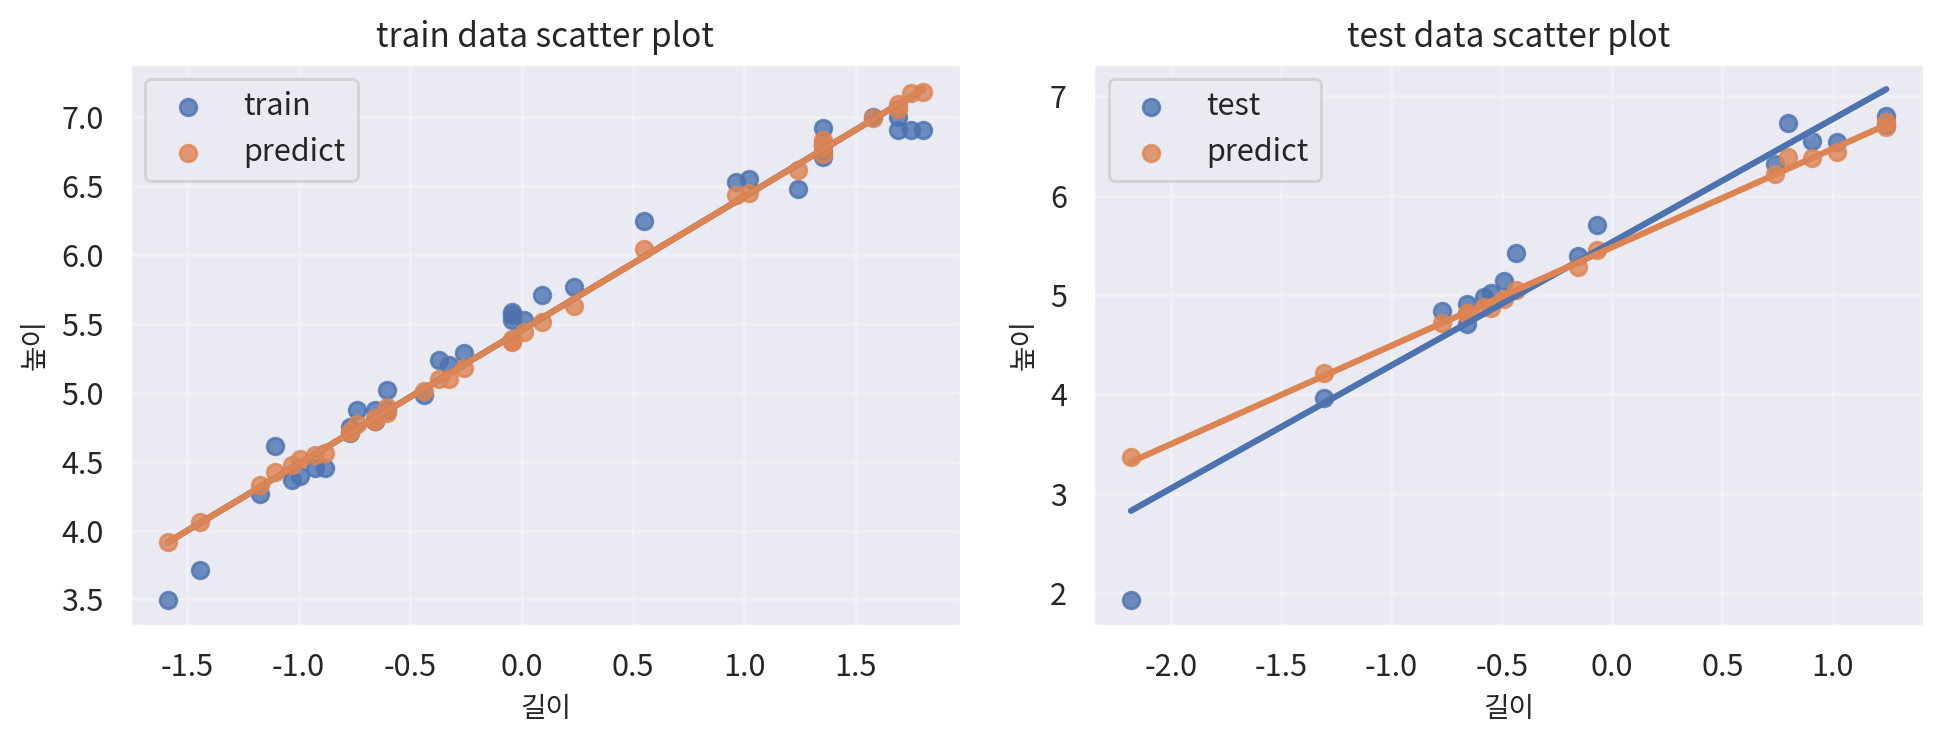

In [ ]:
# 훈련, 검증 데이터에 대한 추정치 얻기
y1 = estimator.predict(x_train)
y2 = estimator.predict(x_test)

figsize = (2000 / my_dpi, 800 / my_dpi)
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=my_dpi)
fig.subplots_adjust(wspace=0.2, hspace=0.2)

# 훈련 데이터 시각화
sb.regplot(data=x_train, x="길이", y=y_train, ci=0, label="train", ax=ax[0])
sb.regplot(data=x_train, x="길이", y=y1, ci=0, label="predict", ax=ax[0])
ax[0].set_title("train data scatter plot", fontsize=12)
ax[0].set_xlabel("길이", fontsize=10)
ax[0].set_ylabel("높이", fontsize=10)
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# 검증 데이터 시각화
sb.regplot(data=x_test, x="길이", y=y_test, ci=0, label="test", ax=ax[1])
sb.regplot(data=x_test, x="길이", y=y2, ci=0, label="predict", ax=ax[1])
ax[1].set_title("test data scatter plot", fontsize=12)
ax[1].set_xlabel("길이", fontsize=10)
ax[1].set_ylabel("높이", fontsize=10)
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()


## #05 예측
### [1] 가상 데이터 생성후 예측값 만들기

In [ ]:
# 농어의 길이, 높이, 두께에 대한 가상 데이터 생성
new_data = DataFrame(
    {
        "길이": [5.0, 7.0, 5.0],
        "높이": [6.0, 3.0, 3.0],
        "두께": [3.5, 4.0, 2.5],
    }
)

# 중요!! 스케일링이 적용된 변수에는 동일한 스케일링 적용 필요
# fit_transform 아님에 주의
std_new_data = DataFrame(scaler.transform(new_data), columns=new_data.columns)

# 가상 데이터에 대한 무게 예측
predicted_log_weight = estimator.predict(std_new_data)
predicted_weight = np.expm1(predicted_log_weight)

# 소수점 셋째자리까지 반올림하여 저장
new_data["예측된 무게"] = predicted_weight
new_data


,길이,높이,두께,예측된 무게
0,5.0,6.0,3.5,27.894496
1,7.0,3.0,4.0,29.761451
2,5.0,3.0,2.5,23.027363
